<a href="https://colab.research.google.com/github/ErickCastroAlarcon/Neutron_Star/blob/Testeo/Tov_3D%2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
pi = np.pi
rho_in = 1.5 # 1e15
rho_out = 0.8 # 1e15

Ecuacion que queremos usar para resolver el sistema:

$\frac{-B\kappa}{\rho^\alpha} - 2\kappa'\rho + \frac{\kappa'}{B}\rho^{(2+\alpha)}$

In [ ]:
# Ecuacion de estado
def eos(rho, kp,B,alpha):
  return -(B*k)/rho**alpha - 2.0*kp*rho + (kp/B)*rho**(alpha + 2.0)

Ecuacion que usa el paper "Pretel":

$p = A*\rho - B/rho$

In [ ]:
# Ecuacion de estado para r < R_d
def eos1_p(rho, A,k):
    B = A*0.8**2 - k*0.8*1.5**2
    p = A*rho - B/rho
    if p <= 0:
      return 0
    return p

def eos1_rho(p, A, k):
    B = A*0.8**2 - k*0.8*1.5**2
    # Devuelve 0 si p<=0, sino la fórmula
    return np.where(p <= 0, 0, (p + np.sqrt(p**2 + 4*A*B)) / (2*A))

In [ ]:
# Ecuacion de estado para  R_d < r < R
def eos2_p(rho, K, eta):
    return K * rho**(1 + 1/eta)

def eos2_rho(p, K, eta):
    return (p / K)**(eta / (eta + 1))

Otras ecuaciones de estado de prueba:

In [ ]:
def Eos(p, A):
  return p/A
def Eos_inv(rho,A):
  return rho*A

Codigo:

In [ ]:
# Funcion sin usar aun
def initial_conditions(rho_c, eos_p, *params):
    p_c = eos_p(rho_c, *params)
    return [0.0, p_c]  # masa=0, presion=p_c

In [ ]:
def Tov(r, y, rho_p, *params):
  # Evita singularidades numericas
  if r <= 0:
    r = 1e-12

  # Condiciones iniciales
  m, p = y

  if p <= 0:
      return [0, 0]

  # Llamamos a la ecuacion de estado
  rho = rho_p(p,*params)

  # Nuestro sistema de Ecuaciones
  dm_dr = 4.0 * pi * r*r * rho
  dp_dr = -(rho + p)*(m + 4*pi*(r**3) *p)/(r*(r - 2*m))
  #metric_term = -(1/(rho + p)) * dp_dr

  return [dm_dr, dp_dr]

# Evento para detener la integracion
def stop_at_surface(r, y, rho_of_p, *args):
    return y[1]  # condición: presión = 0
stop_at_surface.terminal = True
stop_at_surface.direction = -1

In [ ]:
# Integrar un tramo
def integrar_tramo(r_ini, r_fin, rho_0, N , eos_fun, *params):
  p_of_rho, rho_of_p = eos_fun

  p0 = p_of_rho(rho_0,*params)
  m0 = (4/3)*np.pi * rho_0 * r_ini**3
  y0 = [m0, p0]

  r_eval = np.arange(r_ini, r_fin, N)

  # Integramos
  sol = solve_ivp(
    Tov, (r_ini, r_fin),
    y0,args=(rho_of_p,*params),
    t_eval=r_eval,
    events=stop_at_surface,
    max_step=0.05,rtol=1e-7, atol=1e-9, dense_output=True)

  # Usamos el evento para localizar la superficie:
  if sol.t_events[0].size > 0:
      r_surface = sol.t_events[0][0]
      print(f"Superficie (p=0) detectada en r ≈ {r_surface:.4f}")
  else:
    print("No se encontró la superficie")
    r_surface = 0.0

  # Muestreo uniforme
  y_eval = sol.sol(r_eval)
  m_eval, p_eval = y_eval
  rho_eval = rho_of_p(p_eval, *params)

  return r_eval, m_eval, p_eval, rho_eval, r_surface

In [ ]:
# arreglos de funciones de estado
eos_in = (eos1_p,eos1_rho)
eos_out = (eos2_p, eos2_rho)
eos_test = (Eos, Eos_inv)

No se encontró la superficie


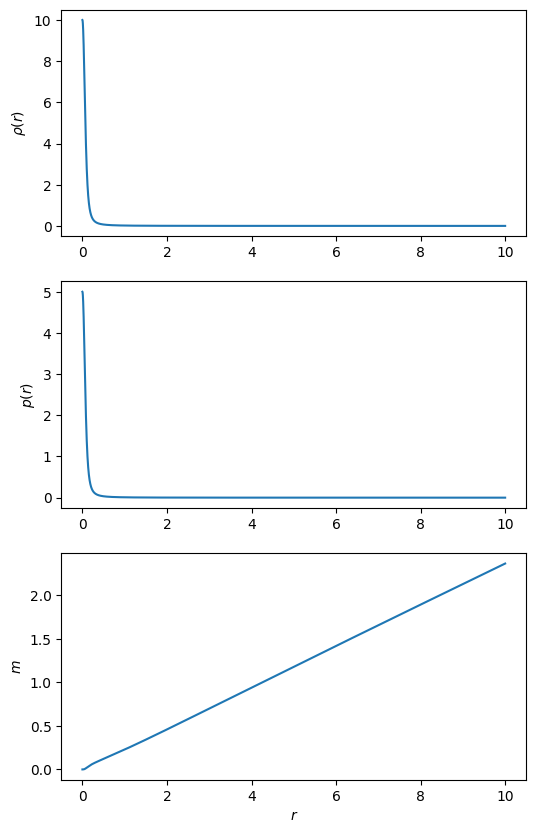

In [ ]:
r0 = 1e-6
N = 1e-5

rho_c = 10 # Densidad Central

A = 2

R_d = 10

r,m,p,rho,R_i, = integrar_tramo(r0,R_d,rho_c,N,eos_test,A)

fig, axs = plt.subplots(3, 1, figsize=(6,10))

axs[0].plot(r, rho)
axs[1].plot(r, p)
axs[2].plot(r, m)
axs[0].set_ylabel(r"$\rho(r)$")
axs[1].set_ylabel(r"$p(r)$")
axs[2].set_ylabel(r"$m$")
axs[2].set_xlabel(r"$r$")
plt.show()

In [ ]:
r0 = 1e-6
N = 1e-5

rho_c = 1.5 # Densidad Central

A = -0.2
k = 100 # fija
eta = 1 # fija

R_d = 10
R = 20

Superficie (p=0) detectada en r ≈ 0.2667


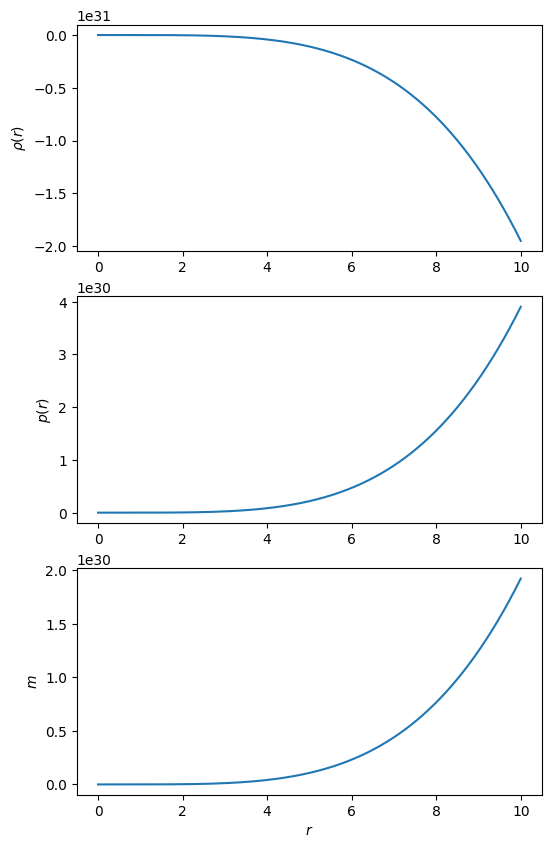

In [ ]:
# Integramos el primer tramo
r,m,p,rho,R_i, = integrar_tramo(r0,R_d,rho_c,N,eos_in,A,k)

#m_sol = 2e30
fig, axs = plt.subplots(3, 1, figsize=(6,10))

axs[0].plot(r, rho)
axs[1].plot(r, p)
axs[2].plot(r, m)
axs[0].set_ylabel(r"$\rho(r)$")
axs[1].set_ylabel(r"$p(r)$")
axs[2].set_ylabel(r"$m$")
axs[2].set_xlabel(r"$r$")
plt.show()


Para generar distintas configuraciones de estrellas integrando ambos tramos:

In [ ]:
def estrella(r0, R_d, R,A,k,eta, N):

  # Integramos el primer tramo
  r,m,p,rho,R_i, = integrar_tramo(r0,R_d,rho_c,N,eos_in,A,k)

  fig, axs = plt.subplots(3, 1, figsize=(6,10))

  axs[0].plot(r, rho)
  axs[1].plot(r, p)
  axs[2].plot(r, m)


  # Empalme en r= R_d
  if R_i == R_d:
    print("Existe continuidad")

  rho_d = rho[-1] # Condicion inicial del segundo tramo

  # Integramos el segundo tramo
  r,m,p,rho,R_star, = integrar_tramo(R_d,R,rho_d,N,eos_out,k,eta)

  print("El radio de la estrella es:", R_star)

  axs[0].plot(r, rho)
  axs[1].plot(r, p)
  axs[2].plot(r, m)

  axs[0].set_ylabel(r"$\rho(r)$")
  axs[1].set_ylabel(r"$p(r)$")
  axs[2].set_ylabel(r"$m(r)$")
  axs[2].set_xlabel(r"$r$")

  plt.show()

In [ ]:
estrella(r0,R_d,R,A,k,eta,N)